In [1]:
import tensorflow as tf
import numpy as np
import itertools
import h5py as h5
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

In [3]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import initializers, optimizers
from keras.layers import Input, BatchNormalization
from keras.layers import  Dense, Flatten, Activation, Dropout, Embedding
from keras.layers import LSTM, TimeDistributed, Permute,Reshape, Lambda, RepeatVector, merge, Input,Multiply
from keras.utils import np_utils
from keras.layers.wrappers import  Bidirectional
from keras.layers import *
from keras import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2 
from keras.models import load_model
import keras

Using TensorFlow backend.


In [4]:
from os import listdir
from os.path import isfile, join
import glob

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [6]:
mypath = '/home/chenming/ncrna/ncRDeep2/Data_Processing/Ten_Fold_Onehot_Data_h5/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [7]:
my_files8 = glob.glob("/home/chenming/ncrna/ncRDeep2/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot*.h5")
my_files8.sort()
my_files8[0:2]

['/home/chenming/ncrna/ncRDeep2/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot_Fold_0_Test_Data_750.h5',
 '/home/chenming/ncrna/ncRDeep2/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot_Fold_0_Train_Data_750.h5']

In [8]:
def get_file8(fold_no): #get train and test data from file by fold number
    hf_Train = h5.File(my_files8[fold_no*2+1],'r')
    hf_Test = h5.File(my_files8[fold_no*2],'r')
    X_train = hf_Train['Train_Data'] # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Train['Label']      # Get train label
    Y_train = np.array(Y_train)
    X_test = hf_Test['Test_Data']     # Get test set
    X_test = np.array(X_test)
    Y_test = hf_Test['Label']       # Get test label
    Y_test = np.array(Y_test)
    Y_train = np_utils.to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = np_utils.to_categorical(Y_test, 13)    #  Process the label of test
    return X_train, Y_train, X_test, Y_test

In [43]:
my_files7 = glob.glob("/home/chenming/ncrna/ncRDeep2/Data_Processing/RNAfold/SS*.h5")
my_files7.sort()
hf_val = h5.File(my_files7[20],'r')
X_val = hf_val['Test_Data']     # Get test set
X_val = np.array(X_val)
Y_val = hf_val['Label']       # Get test label
Y_val = np.array(Y_val)
Y_val = np_utils.to_categorical(Y_val, 13)    #  Process the label of test

In [22]:
my_files6 = glob.glob("/home/chenming/ncrna/ncRDeep2/Data_Processing/ENAC/T*")
my_files6.sort()
my_files6[0:2]

['/home/chenming/ncrna/ncRDeep2/Data_Processing/ENAC/Test_enac_0.txt',
 '/home/chenming/ncrna/ncRDeep2/Data_Processing/ENAC/Test_enac_1.txt']

In [25]:
def get_enac(fold_no):
    enac_test = my_files6[fold_no]
    enac_train = my_files6[10+fold_no]
    enac_test_lines = loadtxt(enac_test, delimiter="\t", unpack=False)
    enac_train_lines = loadtxt(enac_train, delimiter="\t", unpack=False)
    enac_test_lines = np.delete(enac_test_lines, 0, 1)
    enac_train_lines = np.delete(enac_train_lines, 0, 1)
    enac_test_lines = enac_test_lines.reshape(632,750,4)
    enac_train_lines = enac_train_lines.reshape(5688,750,4)
    return enac_train_lines, enac_test_lines

In [44]:
enac_val = my_files6[20]
enac_val_lines = loadtxt(enac_test, delimiter="\t", unpack=False)
enac_val_lines = np.delete(enac_val_lines, 0, 1)
enac_val_lines.shape
enac_val = enac_val_lines.reshape(2600,750,4)

In [26]:
X_train_enac, X_test_enac = get_enac(0)

In [27]:
X_train_enac.shape

(5688, 750, 4)

In [28]:
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    FONT_SIZE = 10
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n============================")
    else:
        #cm = np.asfarray(cm,float64)
        print('Confusion matrix, without normalization\n============================')
    #print(cm)
    plt.figure(figsize=(5*2, 4*2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=FONT_SIZE)
    plt.yticks(tick_marks, classes, fontsize=FONT_SIZE)
    fmt = '.3f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    fontsize=FONT_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=FONT_SIZE)
    plt.xlabel('Predicted label', fontsize=FONT_SIZE)
    plt.savefig('Conf_mat_avg.pdf')
    plt.show()

In [29]:
#class_names = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
class_names = ['5S_rRNA', '5.8S_rRNA', 'tRNA', 'ribozymes', 'CD-box', 'miRNA', 'Intron_gpI', 'Intron_gpII', 'HACA-box', 'riboswitch', 'IRES', 'leader', 'scaRNA']
class_names

['5S_rRNA',
 '5.8S_rRNA',
 'tRNA',
 'ribozymes',
 'CD-box',
 'miRNA',
 'Intron_gpI',
 'Intron_gpII',
 'HACA-box',
 'riboswitch',
 'IRES',
 'leader',
 'scaRNA']

In [10]:
enac_train = '/home/chenming/ncrna/ncRDeep2/Data_Processing/ENAC/train_0.txt'
enac_test = '/home/chenming/ncrna/ncRDeep2/Data_Processing/ENAC/test_0.txt'

In [11]:
num_lines = sum(1 for line in open(enac_test, 'r'))

In [12]:
num_lines

632

In [14]:
from numpy import loadtxt


In [34]:
def model_conv(f1,k1,f2,k2): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 4))
    
    x=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs1)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)

    x=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    x = BatchNormalization()(x)
    x=Dropout(0.2)(x)
    x=Activation('relu')(x)
    x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    #x=Conv1D(filters=32,kernel_size=2,strides=1,kernel_initializer=initializers.random_uniform()) (x)
    #x = BatchNormalization()(x)
    #x=Dropout(0.2)(x)
    #x=Activation('relu')(x)
    #x=MaxPooling1D(pool_size=2, strides=2)(x)
    
    xx=Conv1D(filters=f1,kernel_size=k1,strides=1,kernel_initializer=initializers.random_uniform()) (inputs2)
    xx = BatchNormalization()(xx)
    xx=Dropout(0.2)(xx)
    xx=Activation('relu')(xx)
    xx=MaxPooling1D(pool_size=2, strides=2)(xx)

    xx=Conv1D(filters=f2,kernel_size=k2,strides=1,kernel_initializer=initializers.random_uniform()) (xx)
    xx = BatchNormalization()(xx)
    xx=Dropout(0.2)(xx)
    xx=Activation('relu')(xx)
    xx=MaxPooling1D(pool_size=2, strides=2)(xx)
    
    x2=keras.layers.concatenate([xx,x],axis=1)
    
    x2=Conv1D(filters=64,kernel_size=4,strides=1,kernel_initializer=initializers.random_uniform()) (x2)
    x2 = BatchNormalization()(x2)
    x2=Dropout(0.2)(x2)
    x2=Activation('relu')(x2)
    x2=MaxPooling1D(pool_size=2, strides=2)(x2)

    x2=Flatten()(x2)

    x3=Dense(128,)(x2)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(32,)(x3)
    x3 = BatchNormalization()(x3)
    x3=Dropout(0.3)(x3)
    x3=Activation('relu')(x3)

    x3=Dense(13, activation='softmax',  )(x3)

    model = Model(inputs=[inputs1, inputs2], outputs=x3)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [19]:
X_train, Y_train, X_test, Y_test = get_file8(0)


In [35]:
model = model_conv(512, 20, 128, 6)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 750, 4)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 750, 4)       0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 731, 512)     41472       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 731, 512)     41472       input_1[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [36]:
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file8(i)
    X_train_enac, X_test_enac = get_enac(i)
    model = model_conv(512, 20, 128, 6)
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train[:,:,0:4],X_train_enac], Y_train, validation_data=([X_test[:,:,0:4],X_test_enac], Y_test), epochs=500, verbose=0, callbacks=[es])
    #model.save_weights("Checkpoints/Dense_RNAfold_1003conv_%i_fold.h5" %i)
    y = model.predict([X_test[:,:,0:4],X_test_enac])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.9034810126582279, 0.8966346153846154, 0.9039164292408315, 0.8986894502030763, 0.8955190461493051)
(0.8860759493670886, 0.8797115384615384, 0.8957641130300755, 0.8845257390907386, 0.8769092095537339)
(0.9018987341772152, 0.8976923076923076, 0.9090404496552227, 0.9008900027747365, 0.893879982024359)
(0.8829113924050633, 0.8783653846153846, 0.8909556128301426, 0.8811519547902112, 0.8739020480971251)
(0.9082278481012658, 0.9029807692307693, 0.9095549917093473, 0.9045340881013865, 0.9007955593616094)
(0.9113924050632911, 0.9060576923076925, 0.915237388502259, 0.9083809245094567, 0.9042317943346105)
(0.8955696202531646, 0.8880769230769232, 0.90776315193804, 0.8920425493947399, 0.887748150325864)
(0.8955696202531646, 0.8846153846153846, 0.9141236424639787, 0.8895294536639907, 0.8879407022562357)
(0.9003164556962026, 0.8909615384615385, 0.9051717809693425, 0.8940580861349214, 0.8922514773782745)
(0.9113924050632911, 0.9051923076923075, 0.9144921666198262, 0.9077987558940139, 0.9041190023678

In [37]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.8996835443037975
0.8930288461538461
0.9066019726959066
0.8961601004557271
0.8917296971848954


In [22]:

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit([X_train,enac_train_lines], Y_train, validation_data=([X_test,enac_test_lines], Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict([X_test,enac_test_lines])
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 14s 3ms/step - loss: 2.2454 - acc: 0.2683 - val_loss: 1.8645 - val_acc: 0.4509
Epoch 2/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.8303 - acc: 0.4350 - val_loss: 1.7502 - val_acc: 0.5301
Epoch 3/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.6258 - acc: 0.5156 - val_loss: 1.6530 - val_acc: 0.5981
Epoch 4/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.5087 - acc: 0.5693 - val_loss: 1.6353 - val_acc: 0.5902
Epoch 5/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.3932 - acc: 0.6079 - val_loss: 1.5094 - val_acc: 0.6598
Epoch 6/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.3104 - acc: 0.6368 - val_loss: 1.4386 - val_acc: 0.6693
Epoch 7/500
5688/5688 [==============================] - 8s 1ms/step - loss: 1.2201 - acc: 0.6749 - val_loss: 1.3416 - val_acc: 0.6946
Epoch 8

Epoch 61/500
5688/5688 [==============================] - 9s 1ms/step - loss: 0.0789 - acc: 0.9833 - val_loss: 0.3969 - val_acc: 0.8940
Epoch 62/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0681 - acc: 0.9856 - val_loss: 0.3698 - val_acc: 0.8908
Epoch 63/500
5688/5688 [==============================] - 9s 1ms/step - loss: 0.0685 - acc: 0.9854 - val_loss: 0.4011 - val_acc: 0.8908
Epoch 64/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0686 - acc: 0.9836 - val_loss: 0.3505 - val_acc: 0.9082
Epoch 65/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0648 - acc: 0.9879 - val_loss: 0.3845 - val_acc: 0.8892
Epoch 66/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0716 - acc: 0.9838 - val_loss: 0.4015 - val_acc: 0.8940
Epoch 67/500
5688/5688 [==============================] - 8s 1ms/step - loss: 0.0659 - acc: 0.9868 - val_loss: 0.3491 - val_acc: 0.9082
Epoch 68/500
5688/5688 [========================

In [38]:
def Conv1Dme(f, k, xo):
    x1o=Conv1D(filters=f,kernel_size=k,strides=1,padding="same",kernel_initializer=initializers.random_uniform()) (xo)
    x1o = BatchNormalization()(x1o)
    x1o=Dropout(0.2)(x1o)
    x1o=Activation('relu')(x1o)
    #x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    return x1o

In [39]:
def Conv1Dmax(f, k, x):
    x1=Conv1D(filters=f,kernel_size=k,strides=1,padding="same",kernel_initializer=initializers.random_uniform()) (x)
    x1 = BatchNormalization()(x1)
    x1=Dropout(0.2)(x1)
    x1=Activation('relu')(x1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    return x1

In [40]:
def model_dense1(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(746, 4))
    
    x1 = Conv1Dme(256, 20, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    ###############################################################
    #          1st dense block
    
    f1 = 64

    x1 = Conv1Dme(f1, 5, x1)
    x11 = Conv1Dme(f1, 5, x1)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, 5, x11)
    x1=MaxPooling1D(pool_size=2, strides=2)(x11)
    
    x1 = Conv1Dme(f1, 5, x1)
    x11 = Conv1Dme(f1, 5, x1)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, 5, x11)
    x11=MaxPooling1D(pool_size=2, strides=2)(x11)
        
    #x2 = Conv1Dme(f1, 7, x1)
    #x21 = Conv1Dme(f1, 7, x2)
    #x21 = Concatenate(axis=-1)([x2,x21])
    #x21 = Conv1Dme(f1, 7, x21)
    
    #x3 = Concatenate(axis=-1)([x11,x21])
    #x3 = Conv1Dme(64, 5, x3)
    #x3=MaxPooling1D(pool_size=2, strides=2)(x3)
    
       
    ###############################################################
    
    xx1 = Conv1Dme(256, 20, inputs2)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    ###############################################################
    #          1st parallel dense block
    
    f1 = 64

    xx1 = Conv1Dme(f1, 5, xx1)
    xx11 = Conv1Dme(f1, 5, xx1)
    xx11 = Concatenate(axis=-1)([xx1,xx11])
    xx11 = Conv1Dme(f1, 5, xx11)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx11)
    
    xx1 = Conv1Dme(f1, 5, xx1)
    xx11 = Conv1Dme(f1, 5, xx1)
    xx11 = Concatenate(axis=-1)([xx1,xx11])
    xx11 = Conv1Dme(f1, 5, xx11)
    xx11=MaxPooling1D(pool_size=2, strides=2)(xx1)
        
    #xx2 = Conv1Dme(f1, 7, xx1)
    #xx21 = Conv1Dme(f1, 7, xx2)
    #xx21 = Concatenate(axis=-1)([xx2,xx21])
    #xx21 = Conv1Dme(f1, 7, xx21)
    
    #xx3 = Concatenate(axis=-1)([xx11,xx21])
    #xx3 = Conv1Dme(64, 5, xx3)
    #xx3=MaxPooling1D(pool_size=2, strides=2)(xx3)
    
    ###############################################################
    #          FC block
    
    xxx=keras.layers.concatenate([xx11,x11],axis=1)
    
    xxx = Conv1Dme(32, 3, xxx)
    xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
    
    xf=Flatten()(xxx)

    xf=Dense(128,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(32,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1, inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [43]:
model = model_dense1()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 750, 4)       0                                            
__________________________________________________________________________________________________
conv1d_137 (Conv1D)             (None, 750, 256)     20736       input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_153 (BatchN (None, 750, 256)     1024        conv1d_137[0][0]                 
__________________________________________________________________________________________________
dropout_153 (Dropout)           (None, 750, 256)     0           batch_normalization_153[0][0]    
__________________________________________________________________________________________________
activation

In [93]:
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit([X_train,enac_train_lines], Y_train, validation_data=([X_test,enac_test_lines], Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict([X_test,enac_test_lines])
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 43s 8ms/step - loss: 2.2085 - acc: 0.2716 - val_loss: 2.2845 - val_acc: 0.2089
Epoch 2/500
5688/5688 [==============================] - 16s 3ms/step - loss: 1.7199 - acc: 0.4564 - val_loss: 2.0706 - val_acc: 0.3766
Epoch 3/500
5688/5688 [==============================] - 17s 3ms/step - loss: 1.4677 - acc: 0.5522 - val_loss: 1.9126 - val_acc: 0.4146
Epoch 4/500
5688/5688 [==============================] - 16s 3ms/step - loss: 1.2957 - acc: 0.5962 - val_loss: 1.8848 - val_acc: 0.3608
Epoch 5/500
5688/5688 [==============================] - 16s 3ms/step - loss: 1.1773 - acc: 0.6399 - val_loss: 1.8671 - val_acc: 0.3481
Epoch 6/500
5688/5688 [==============================] - 16s 3ms/step - loss: 1.0780 - acc: 0.6728 - val_loss: 1.7614 - val_acc: 0.4066
Epoch 7/500
5688/5688 [==============================] - 17s 3ms/step - loss: 0.9812 - acc: 0.7133 - val_loss: 1.6336 - val_acc: 0.4509
E

In [47]:
def dense_block_1(xin, f, k):
    f1 = f
    k1 = k

    x1 = Conv1Dme(f1, k1, xin)
    x11 = Conv1Dme(f1, k1, x1)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x1=MaxPooling1D(pool_size=2, strides=2)(x11)
    
    return x1

In [134]:
def model_dense1(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(746, 4))
    
    x1 = Conv1Dme(64, 3, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    ###############################################################
    #          1st dense block
    
    x1 = dense_block_1(x1, 128, 4)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
    
       
    xx1 = Conv1Dme(64, 3, inputs2)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    ###############################################################
    #          1st dense block
    
    xx1 = dense_block_1(xx1, 128, 4)
    xx1 = dense_block_1(xx1, 256, 5)
    xx1 = dense_block_1(xx1, 256, 5)
    
    xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    xxx = Conv1Dme(64, 3, xxx)
    xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
        
    xf=Flatten()(xxx)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [135]:
model = model_dense1()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           (None, 750, 4)       0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           (None, 746, 4)       0                                            
__________________________________________________________________________________________________
conv1d_538 (Conv1D)             (None, 750, 64)      832         input_73[0][0]                   
__________________________________________________________________________________________________
conv1d_551 (Conv1D)             (None, 746, 64)      832         input_74[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [136]:
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit([X_train,enac_train_lines], Y_train, validation_data=([X_test,enac_test_lines], Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict([X_test,enac_test_lines])
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 74s 13ms/step - loss: 2.4207 - acc: 0.1999 - val_loss: 2.8186 - val_acc: 0.0902
Epoch 2/500
5688/5688 [==============================] - 23s 4ms/step - loss: 2.0059 - acc: 0.3477 - val_loss: 2.8739 - val_acc: 0.0791
Epoch 3/500
5688/5688 [==============================] - 23s 4ms/step - loss: 1.7967 - acc: 0.4255 - val_loss: 2.8615 - val_acc: 0.1266
Epoch 4/500
5688/5688 [==============================] - 23s 4ms/step - loss: 1.6242 - acc: 0.4759 - val_loss: 3.0503 - val_acc: 0.1218
Epoch 5/500
5688/5688 [==============================] - 23s 4ms/step - loss: 1.4844 - acc: 0.5390 - val_loss: 2.9217 - val_acc: 0.1392
Epoch 6/500
5688/5688 [==============================] - 23s 4ms/step - loss: 1.3796 - acc: 0.5703 - val_loss: 2.9495 - val_acc: 0.1377
Epoch 7/500
5688/5688 [==============================] - 23s 4ms/step - loss: 1.2810 - acc: 0.6002 - val_loss: 2.9831 - val_acc: 0.1282


In [103]:
enac_pad = np.zeros((632,2,4))
enac_pad2 = np.zeros((5688,2,4))
enac_test_last = np.concatenate((enac_pad,enac_test_lines,enac_pad),axis=1)
enac_train_last = np.concatenate((enac_pad2,enac_train_lines,enac_pad2),axis=1)

In [41]:
def model_dense2(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 4))
    
    x1=keras.layers.concatenate([inputs1,inputs2],axis=-1)
    
    ###############################################################
    #          1st dense block
    
    #x11 = Conv1Dme(128, 3, x1)
    #x11=MaxPooling1D(pool_size=2, strides=2)(x11)
    
    #x12 = Conv1Dme(128, 5, x1)
    #x12=MaxPooling1D(pool_size=2, strides=2)(x12)
    
    #x1=keras.layers.concatenate([x11,x12],axis=-1)
    
    x1 = Conv1Dme(128, 3, x1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 3)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
    
       
    ###############################################################
    #          2nd dense block
    
    #xx1 = Conv1Dme(64, 3, inputs2)
    #xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    
    
    #xx1 = dense_block_1(xx1, 128, 4)
    #xx1 = dense_block_1(xx1, 256, 5)
    #xx1 = dense_block_1(xx1, 256, 5)
    
    ###############################################################
    #           Concatenating
    
    #xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    #xxx = Conv1Dme(64, 3, xxx)
    #xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
        
    xf=Flatten()(x1)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [154]:
model = model_dense2()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           (None, 750, 4)       0                                            
__________________________________________________________________________________________________
input_86 (InputLayer)           (None, 750, 4)       0                                            
__________________________________________________________________________________________________
concatenate_287 (Concatenate)   (None, 750, 8)       0           input_85[0][0]                   
                                                                 input_86[0][0]                   
__________________________________________________________________________________________________
conv1d_631 (Conv1D)             (None, 750, 128)     3200        concatenate_287[0][0]            
__________

In [152]:
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit([X_train,enac_train_last], Y_train, validation_data=([X_test,enac_test_last], Y_test), epochs=500, verbose=1, callbacks=[es])
y = model.predict([X_test,enac_test_last])
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y ]
auc = accuracy_score(y_test_non_category, y_predict_non_category)
print(auc)

Train on 5688 samples, validate on 632 samples
Epoch 1/500
5688/5688 [==============================] - 65s 11ms/step - loss: 2.2802 - acc: 0.2523 - val_loss: 2.6809 - val_acc: 0.0886
Epoch 2/500
5688/5688 [==============================] - 15s 3ms/step - loss: 1.9324 - acc: 0.3680 - val_loss: 2.8840 - val_acc: 0.0918
Epoch 3/500
5688/5688 [==============================] - 15s 3ms/step - loss: 1.6966 - acc: 0.4580 - val_loss: 2.7198 - val_acc: 0.1408
Epoch 4/500
5688/5688 [==============================] - 15s 3ms/step - loss: 1.4845 - acc: 0.5389 - val_loss: 2.3402 - val_acc: 0.2547
Epoch 5/500
5688/5688 [==============================] - 15s 3ms/step - loss: 1.3157 - acc: 0.5942 - val_loss: 2.1528 - val_acc: 0.3196
Epoch 6/500
5688/5688 [==============================] - 15s 3ms/step - loss: 1.2091 - acc: 0.6338 - val_loss: 1.9563 - val_acc: 0.3576
Epoch 7/500
5688/5688 [==============================] - 15s 3ms/step - loss: 1.1002 - acc: 0.6695 - val_loss: 1.9191 - val_acc: 0.3750


In [156]:
for i in range(3):
    model = model_dense2()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train,enac_train_last], Y_train, validation_data=([X_test,enac_test_last], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test,enac_test_last])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.8639240506329114
0.9066455696202531
0.9113924050632911


In [163]:
def model_dense3(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 4))
    
    #x1=keras.layers.concatenate([inputs1,inputs2],axis=-1)
    
    ###############################################################
    #          1st dense block
    
    #x11 = Conv1Dme(128, 3, x1)
    #x11=MaxPooling1D(pool_size=2, strides=2)(x11)
    
    #x12 = Conv1Dme(128, 5, x1)
    #x12=MaxPooling1D(pool_size=2, strides=2)(x12)
    
    #x1=keras.layers.concatenate([x11,x12],axis=-1)
    
    x1 = Conv1Dme(128, 3, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 3)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
    
       
    ###############################################################
    #          2nd dense block
    
    xx1 = Conv1Dme(128, 3, inputs2)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    
    
    xx1 = dense_block_1(xx1, 128, 3)
    xx1 = dense_block_1(xx1, 256, 5)
    xx1 = dense_block_1(xx1, 256, 5)
    
    ###############################################################
    #           Concatenating
    
    xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    #xxx = Conv1Dme(64, 3, xxx)
    #xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
        
    xf=Flatten()(xxx)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [164]:
for i in range(3):
    model = model_dense3()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train,enac_train_last], Y_train, validation_data=([X_test,enac_test_last], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test,enac_test_last])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.9098101265822784
0.8987341772151899
0.8892405063291139


In [167]:
def model_dense3(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 4))
    
    #x1=keras.layers.concatenate([inputs1,inputs2],axis=-1)
    
    ###############################################################
    #          1st dense block
    
    #x11 = Conv1Dme(128, 3, x1)
    #x11=MaxPooling1D(pool_size=2, strides=2)(x11)
    
    #x12 = Conv1Dme(128, 5, x1)
    #x12=MaxPooling1D(pool_size=2, strides=2)(x12)
    
    #x1=keras.layers.concatenate([x11,x12],axis=-1)
    
    x1 = Conv1Dme(128, 3, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 3)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
    
       
    ###############################################################
    #          2nd dense block
    
    xx1 = Conv1Dme(128, 3, inputs2)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    
    
    xx1 = dense_block_1(xx1, 128, 3)
    xx1 = dense_block_1(xx1, 256, 5)
    xx1 = dense_block_1(xx1, 256, 5)
    
    ###############################################################
    #           Concatenating
    
    xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    xxx = Conv1Dme(64, 3, xxx)
    xxx=MaxPooling1D(pool_size=2, strides=2)(xxx)
        
    xf=Flatten()(xxx)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [168]:
for i in range(3):
    model = model_dense3()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train,enac_train_last], Y_train, validation_data=([X_test,enac_test_last], Y_test), epochs=500, verbose=0, callbacks=[es])
    y = model.predict([X_test,enac_test_last])
    y_test_non_category = [ np.argmax(t) for t in Y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    print(auc)
    i=i+1

0.9018987341772152
0.9066455696202531
0.9003164556962026


In [169]:
precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
classification_reports = classification_report(y_test_non_category, y_predict_non_category)
print(auc,recall,precision,fscore,mcc)

(0.9003164556962026, 0.8952884615384616, 0.902749341607792, 0.896544642700091, 0.8923078819058271)


Confusion matrix, without normalization


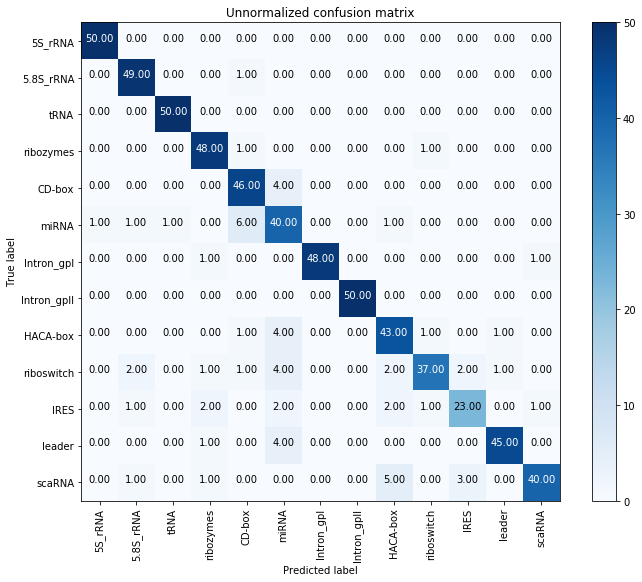

In [172]:
plot_confusion_matrix(conf_mat, classes=class_names, normalize=False,
                        title='Unnormalized confusion matrix')

In [42]:
def model_dense4(): # Model
    inputs1 = Input(shape=(750, 4))
    inputs2 = Input(shape=(750, 4))
    
    ###############################################################
    #          1st dense block
    
    x1 = Conv1Dme(64, 3, inputs1)
    x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    
    x1 = dense_block_1(x1, 128, 4)
    x1 = dense_block_1(x1, 256, 5)
    x1 = dense_block_1(x1, 256, 5)
    
       
    ###############################################################
    #          2nd dense block
    
    xx1 = Conv1Dme(64, 3, inputs2)
    xx1=MaxPooling1D(pool_size=2, strides=2)(xx1)
    
    
    
    xx1 = dense_block_1(xx1, 128, 4)
    xx1 = dense_block_1(xx1, 256, 5)
    xx1 = dense_block_1(xx1, 256, 5)
    
    ###############################################################
    #           Concatenating
    
    xxx=keras.layers.concatenate([x1,xx1],axis=-1)
    
    xxx = dense_block_1(xxx, 256, 4)
        
    xf=Flatten()(xxx)

    xf=Dense(256,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)
    
    xf=Dense(64,)(xf)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=Activation('relu')(xf)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=[inputs1,inputs2], outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['accuracy'])
    
    return model

In [65]:
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(10):
    X_train, Y_train, X_test, Y_test = get_file8(i)
    X_train_enac, X_test_enac = get_enac(i)
    model = model_dense4()
    #es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    #history = model.fit([X_train[:,:,0:4],X_train_enac], Y_train, validation_data=([X_test[:,:,0:4],X_test_enac], Y_test), epochs=500, verbose=0, callbacks=[es])
    model.load_weights("Checkpoints/Dense_ENAC_%i_fold.h5" %i)
    y = model.predict([X_val[:,:,0:4],enac_val])
    y_test_non_category = [ np.argmax(t) for t in Y_val ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0.9111538461538462, 0.9111538461538461, 0.917425762586435, 0.9119182995867678, 0.9041295532739397)
(0.9292307692307692, 0.9292307692307691, 0.9348943475079114, 0.9301434954599762, 0.9237012587927157)
(0.9180769230769231, 0.9180769230769231, 0.9211819878525715, 0.9183215776156375, 0.9114607996864601)
(0.9161538461538462, 0.9161538461538462, 0.9201616456964785, 0.915932902556817, 0.9095633752858903)
(0.9146153846153846, 0.9146153846153845, 0.9198762952148231, 0.9138403874174983, 0.9080413481908711)
(0.9142307692307692, 0.9142307692307692, 0.924091598176918, 0.9156750783355933, 0.9078458658307987)
(0.9211538461538461, 0.921153846153846, 0.9281043117258374, 0.9227985643128539, 0.9149741870404311)
(0.9134615384615384, 0.9134615384615384, 0.9182809759082827, 0.9137408333424049, 0.9066362744688605)
(0.9173076923076923, 0.9173076923076924, 0.9207077219943779, 0.9166390723171394, 0.9108539523365007)
(0.9253846153846154, 0.9253846153846155, 0.92921491892905, 0.9246333633934172, 0.91965019965665

In [66]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.9180769230769231
0.9180769230769231
0.9233939565592685
0.9183643574338104
0.9116856814563119


In [69]:
#auc_mat_750c1 = []
#history_750c1 = []
#conf_mat_750c1 = []
#history_750c1 = {}
#class_report_750c1 = {}
for i in range(1):
    i=5
    X_train, Y_train, X_test, Y_test = get_file8(i)
    X_train_enac, X_test_enac = get_enac(i)
    model = model_dense4()
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit([X_train[:,:,0:4],X_train_enac], Y_train, validation_data=([X_test[:,:,0:4],X_test_enac], Y_test), epochs=500, verbose=0, callbacks=[es])
    model.save_weights("Checkpoints/Dense_ENAC_%i_fold.h5" %i)
    y = model.predict([X_val[:,:,0:4],enac_val])
    y_test_non_category = [ np.argmax(t) for t in Y_val ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(auc,recall,precision,fscore,mcc)
    #auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_750c1['fold%i'%i]=history.history
    #conf_mat_750c1.append([conf_mat])
    #class_report_750c1['fold%i'%i]=classification_reports

(0.9196153846153846, 0.9196153846153847, 0.9228937999547887, 0.9196492543422955, 0.9131875899047388)


In [53]:
enac_val.shape

(2600, 750, 4)